## A test space for a new metric ##

When writing and testing a new metric, it can be helpful to write the Metric class in a notebook and then run it on a single point in the sky (or a single data slice, if you're working on a metric that is not spatially varying). 
This notebook is just a way to get set up to do that writing.

In [1]:
# Some modules you're likely to want .. add whatever is needed.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline   
# %matplotlib notebook

In [3]:
# Import MAF
import rubin_sim.maf as maf

You need to identify the opsim output to run on, so let's do that first. <br>
It's easy to use the current baseline simulation included with $RUBIN_SIM_DATA_DIR, so let's start with that.

In [4]:
from rubin_sim.data import get_baseline

opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/Users/lynnej/rubin_sim_data/sim_baseline/baseline_v2.1_10yrs.db
baseline_v2.1_10yrs


And let's set up a slicer that will give us the observations that overlap a single point on the sky.

In [5]:
# Specify ra / dec of the point we want to work with on the sky - in degrees. 
# (these can be lists, if you want to work on multiple, limited points on the sky)
test_ra = 0.0
test_dec = -20.0
test_slicer = maf.UserPointsSlicer(test_ra, test_dec)

Now set up to work with our Metric. Remember that the Metric will work on a single DataSlice at a time -- so 
*all* of (and *only*) the observation information it receives will be the visits relevant to this test_ra/test_dec location.

In [21]:
class MyMetricInProgress(maf.BaseMetric):
    """Documentation please. Numpy style docstrings. 
    
    This example metric just finds the time of first observation of a particular part of the sky.
    
    Parameters
    ----------
    specificColumns : `str`, opt
        It's nice to be flexible about what the relevant columns are called, so specify them here.
        seeingCol = FWHMeff, etc. 
    kwargs : `float`, ? 
        Probably there are other things you need to set?
    """
    def __init__(self, mjdCol='observationStartMJD', **kwargs):
        self.mjdCol = mjdCol
        cols = [self.mjdCol, ] # Add any columns that your metric needs to run -- mjdCol is just an example
        super().__init__(col=cols, units='#', **kwargs)
        
    def run(self, dataSlice, slicePoint=None):
        # This is where you write what your metric does. 
        # dataSlice == the numpy recarray containing the pointing information, 
        # with the columns that you said you needed in 'cols'
        # slicePoint == the information about where you're evaluating this on the sky -- ra/dec,
        # and if you specified that you need a dustmap or stellar density map, etc., those values will also 
        # be defined here
        
        # here's a super simple example .. replace with your own code to calculate your metric values
        tMin = dataSlice[self.mjdCol].min()
        return tMin
    
# When you re-run this cell, you may get a warning that the metric name already exists - that's ok! 

The typical way to use this metric with a slicer within MAF would be as follows: 

In [7]:
# Set up the metric
mymetric = MyMetricInProgress()

In [8]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
sqlconstraint = None   # no constraint, make all visits available

# Examples of other potentially useful sqlconstraints:
# sqlconstraint = 'filter = "r"'  # just select the visits in a particular filter
# sqlconstraint = 'note not like "%DD%"'  # don't choose any of the DD field visits
# sqlconstraint = 'night < 365'  # only use visits in the first year of the survey

In [9]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, runName=runName)

In [10]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'test_metric': bundle}, opsim_fname, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying table None with no constraint for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'rotSkyPos'].
Found 2081749 visits
Running:  ['test_metric']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


And then you can look at the `bundle.metricValues` to see what your metric calculated and how well things worked.

In [11]:
bundle.metricValues

masked_array(data=[60222.255208384144],
             mask=[False],
       fill_value=-666.0)

BUT, when you're testing a new metric, you might run this many times over .. and querying the database each time is not necessary, if you are re-using the same columns from the database. If you're re-using exactly the same data (same columns, same sqlconstraint), you can skip the query.

In [12]:
# g.simData is the simulation visit data that the previous MetricBundleGroup queried from the database
g.simData[0:2]

rec.array([(60218.00180556, -60.81292802, 310.0244801 , -297.24922531),
           (60218.00225414, -63.56142457, 310.60187065, -297.70827792)],
          dtype=[('observationStartMJD', '<f8'), ('fieldDec', '<f8'), ('fieldRA', '<f8'), ('rotSkyPos', '<f8')])

In [14]:
# redefine your metric and rerun the cell where it was defined (above) - 
#  I'll swap the minimum time to the maximum, for this example, just so you can see the result changed 
# and then set up a new metric object:
mymetric = MyMetricInProgress()  # version X
# and set up a new MetricBundle object 
bundle = maf.MetricBundle(mymetric, test_slicer, sqlconstraint, runName=runName)

# Then set up a NEW and DIFFERENTLY NAMED MetricBundleGroup
g2 = maf.MetricBundleGroup({'test_metric': bundle}, opsim_fname, outDir='test', resultsDb=None)

In [15]:
# But then run it like this: 
g2.runCurrent(simData=g.simData, constraint=sqlconstraint)

Running:  ['test_metric']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [16]:
# See new bundle metric values
bundle.metricValues

masked_array(data=[63869.25770137334],
             mask=[False],
       fill_value=-666.0)

Once you are satisifed your metric is working as you expect, it's time to calculate it on a larger scale. 
Let's assume we now want to calculate the (max) time of observation at each point all over the sky. 

In [17]:
# Same metric 
mymetric = MyMetricInProgress()
# Same constraint 
constraint = sqlconstraint

# NEW SLICER
slicer = maf.HealpixSlicer(nside=64)

# Then setup a metric bundle
allsky_bundle = maf.MetricBundle(mymetric, slicer, constraint, runName=runName)

# To avoid overwriting the previous metric bundle group (and simdata) I'll just make a new one
g_sky = maf.MetricBundleGroup({'all sky': allsky_bundle}, opsim_fname, outDir='test', resultsDb=None)

g_sky.runAll()

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying table None with no constraint for columns ['observationStartMJD', 'fieldDec', 'fieldRA', 'rotSkyPos'].
Found 2081749 visits
Running:  ['all sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


You'll find that this wrote your metric outputs to disk (in `outDir`) and the metric values are still available in the bundle. You can also plot this now. 

In [18]:
allsky_bundle.metricValues

masked_array(data=[--, --, --, ..., 63772.01287145551, 63772.01287145551,
                   63870.04303481139],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=-1.6375e+30)

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/mafUtils.py:141: UserWarning: Optimal bin calculation tried to make 477 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

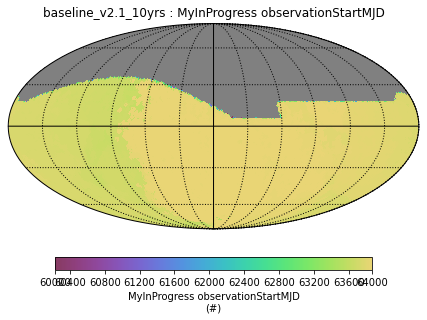

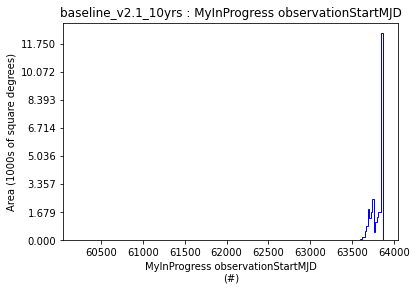

In [19]:
allsky_bundle.plot()

The MAF tutorials in rubin_sim_notebooks/maf/tutorials have more information on running with different slicers and making prettier versions of your output plots or calculating summary statistics on the metric values. 